# Practice with stellar astrometry
To accompany astrometry lecture from the Rubin Observatory Data Science Fellows Program, July 2020.

All questions and corrections can be directed to me at garyb@physics.upenn.edu

Enjoy!

_Gary Bernstein, 16 July 2020_

In [1]:
# Load the packages we will use
import numpy as np
import astropy.io.fits as pf
import astropy.coordinates as co
from astropy.wcs import WCS
from matplotlib import pyplot as pl
%matplotlib inline

## Useful tools
First I'm going to give you one class and one function that will be needed for the first couple of problems.  The class called `MoffatPSF` describes a PSF with the following circular profile:
$$ I(r) \propto \left[1 + (r/r_0)^2\right]^{-\beta}.$$
Many ground-based PSFs look more like this Moffat function than they do like a Gaussian, so let's use this for our astrometry experiments.  We'll stick with $\beta=2.5$ When you create a `MoffatPSF`, you give it the  `half_light_radius` $r_{1/2}$ which encloses half of the light, rather than giving it $r_0.$  You also give the coordinates $(x_0,y_0)$ of the center of the star.  All of these arguments we'll assume to be in units of pixels.

Once you have made a `MoffatPSF`, you can do a few things with it:
* `draw` a picture of the PSF as a 2d image (such that it sums to unity)
* `realizeXY` will return you the (x,y) pixel locations of arrival for one observation of the star - including Poisson noise.
* `realizeImage` will return you a 2d array that is the pixelized image of the arriving photons.

If you're curious you can look inside the class to see how it's done - I've used a few non-obvious tricks to make this fast since we want to create a lot of star images. There is a common trick of random-number generation when we are picking photon locations, where we transform a uniform deviate (which computers are good at) using a function that creates some desired distribution instead.  But you don't need to understand this to do the problems.

Then there is a function `addBackground` which will add background noise of a chosen level (denoted as $n$ in the lecture notes) to any image.

In [2]:
# Make a Moffat class to draw
class MoffatPSF:
    def __init__(self,half_light_radius=4., x0=15.75,y0=15.25):
        # Create a Moffat PSF model that is centered at [y0,x0]
        # with the specified half-light radius (given in pixels)
        self.beta = 2.5
        # Calculate r0 from half-light radius
        tmp = np.power(0.5,1./(1-self.beta)) - 1
        self.r0 = half_light_radius / np.sqrt(tmp)
        self.x0 = x0
        self.y0 = y0
        # Factor that makes the integral of PSF be unity:
        self.norm = (self.beta-1) / (np.pi * self.r0**2)
    def draw(self,n_pix=32):
        # Return an array of shape (n_pix,n_pix) drawing the PSF
        # (using numpy convention
        # of zero-indexing and fastest index, x, last)
        
        # First make arrays holding the x and y coordinates
        xy=np.indices( (n_pix,n_pix),dtype=float)
        x = xy[1].copy()
        y = xy[0].copy()
        rsq = np.square(x-self.x0)+np.square(y-self.y0)
        
        # Here's the basic formla for Moffat:
        result = self.norm * np.power(1+rsq/(self.r0**2), -self.beta)
        # Tune up the normalization to unity:
        result /= np.sum(result)
        return result
    def realizeXY(self,n_photon=1e3):
        # Produce an array of the arrival positions of
        # photons, assuming that they are Poisson sample
        # of a mean of n_photon arrivals.
        # The returned array has shape (2,n_detected)
        # where mean of n_detected is n_photon
        
        # First pick total number of photons:
        n_detected = np.random.poisson(n_photon)
        
        # Then distribute them in radius using the trick
        # of inverse cumulative distribution of uniform distribution.
        r_uniform = np.random.random(n_detected)
        rsq = np.power(r_uniform, 1./(1-self.beta))-1.
        r = self.r0 * np.sqrt(rsq)
        
        # Draw position angles at random and produce output
        theta = np.random.random(n_detected) * (2*np.pi)
        return np.stack((r*np.sin(theta)+self.y0,r*np.cos(theta)+self.x0))
    def realizeImage(self,n_pix=32,n_photon=1e3):
        # Returns an image of shape (n_pix,n_pix) which is a 
        # Poisson-noise realization of the PSF having
        # a mean expected flux of n_photon.
        
        # There are two ways to do this: just bin
        # photons from realize_XY, or
        # do a separate Poisson draw for each pixel.
        if n_photon < n_pix*n_pix:
            # The first way is probably faster
            xy = self.realizeXY(n_photon=n_photon)
            # Pixelize the arrival positions
            xy_pix = np.floor(xy+0.5).astype(int)

            # Discard photons out of bounds
            keep = np.logical_and(xy_pix>=0,xy_pix<n_pix)
            keep = np.logical_and(keep[0,:],keep[1,:])
            xy_pix = xy_pix[:,keep]
            
            # Do some fancy footwork to count the photons into 2d
            # bins
            counts = np.bincount(xy_pix[0]*n_pix+xy_pix[1],minlength=n_pix*n_pix)
            counts = counts.reshape(n_pix,n_pix)
            return counts.astype(float)
        else:
            # Better to do a Poisson draw of each pixel
            counts = np.random.poisson(lam=n_photon*self.draw(n_pix),
                                     size=(n_pix,n_pix))
            return counts.astype(float)
        


In [3]:
def addBackground(image, variance):
    # Add Gaussian noise with given variance to each pixel of the image
    image += np.random.normal(scale=np.sqrt(variance),size=image.shape)
    return

Here is one more very helpful hint.  A lot of our activities require us to do sums like $\sum_{x,y} x I_{xy}.$  To do that it'll be very helpful to have numpy arrays that hold the x and y coordinate values of each pixel in an image.  Here I'll make them for you for the case of a 32x32 square image.

Note that the numpy indexing convention places the y coordinate first in the `[y,x]` indexing.  Also the first pixel is number 0.  This differs from the convention used in FITS images, which is that the first pixel is number 1, and the first axis is the `x` axis.

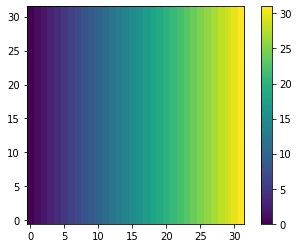

In [4]:
xy=np.indices( (32,32),dtype=float)
x = xy[1].copy()
y = xy[0].copy()
pl.imshow(x,origin='lower',interpolation='nearest')
pl.colorbar()

## Exercise 1: source-dominated centroiding

**(a)** Write a function `centroid(photon_list)` which will estimate the position of a star by taking the average of its x and y photon arrival positions, if it's give a (2,N) array of photon positions such as produced by `MoffatPSF.realizeXY`.

In [5]:
def centroid(photon_list):
    # Returns (y,x) centroids in an array of length 2
    return np.mean(photon_list, axis=1)

**(b)** Now create a `MoffatPSF` instance with a true center of your choice (keep the default `half_light_radius=4`, which fits nicely into 32x32 images).  Make a loop that will create photon lists for each of 10,000 observations of a star with an average flux `n_photon=1e3.`  Use your function from (a) to create estimates $(\hat x_0, \hat y_0)$ of each star.  Then produce a histogram of these 10,000 estimates (one for $x$ and one for $y$), and figure out the standard deviations $\sigma_x$ and $\sigma_y$ of your measurements.

*Tip:* Draw your photon lists 1 at a time, then measure each and throw it away before you draw the next one.  We don't want to use up our memory keeping them all around at once.

X mean, standard deviation: 15.217719049866187 0.1643593686988538
X mean, standard deviation: 16.16926459583192 0.163718471967239


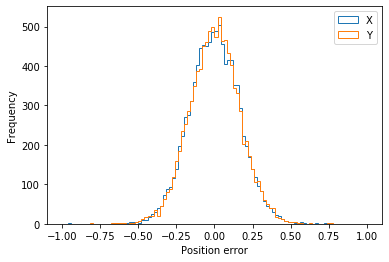

In [6]:
xy = []
x0,y0 = 15.22,16.17
star = MoffatPSF(x0=x0, y0=y0)
# Run my loop of realizations
for i in range(10000):
    xy_i = centroid(star.realizeXY(n_photon=1000.))
    xy.append(xy_i)

# Make the xy estimates into a 2xN numpy array
xy = np.stack(xy).T

# Draw our histograms
h = pl.hist(xy[1]-x0,bins=100,range=(-1,1),histtype='step',label='X')
h = pl.hist(xy[0]-y0,bins=100,range=(-1,1),histtype='step',label='Y')
pl.xlabel('Position error')
pl.ylabel('Frequency')
pl.legend()

# Calculate the standard deviations and means of the estimates
print('X mean, standard deviation:',np.mean(xy[1,:]),np.std(xy[1,:]))
print('X mean, standard deviation:',np.mean(xy[0,:]),np.std(xy[0,:]))


(c) Now see whether our formula for the accuracy of source-limiting centroiding is accurate:
$$ \sigma_x = \frac{\sigma_{\rm PSF}}{\sqrt{N_\gamma}}$$
in this case.  You'll need to use your `MoffatPSF` instance to estimate its standard deviation width $\sigma_{\rm PSF}$.

In [7]:
# Draw a PSF with a lot of photons to measure its std in each axis (they should be the same)
lots_of_photons = star.realizeXY(1e6)
sigma_psf = np.std(lots_of_photons,axis=1)
print("PSF width:",sigma_psf)

# And divide by sqrt(N)
print("Estimated centroid error:",sigma_psf / np.sqrt(1e3))


PSF width: [5.15067287 5.22458036]
Estimated centroid error: [0.16287858 0.16521574]


## Exercise 2: aperture centroids for background-limited stars
Now we're going to work with pixelized images and add background noise (say, $n=4000$). We know that simple centroiding will not be a good idea so we're going to need to use some apertures.  Before proceeding, let's just draw a background-noisy star:

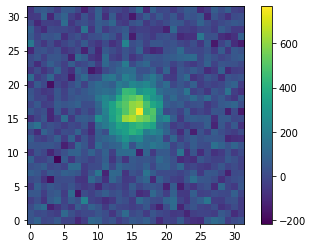

In [8]:
x0,y0 = 15.22,16.17
hlr = 4.
flux = 4e4
n_bg = 4e3
star = MoffatPSF(half_light_radius=4.,x0=x0, y0=y0)
img = star.realizeImage(n_pix=32,n_photon=flux)
addBackground(img, variance=n_bg)
pl.imshow(img,origin='lower',interpolation='nearest')
pl.colorbar()

**(a)** Is this stellar image background-limited or source-limited?  To answer, consider which one contributes more noise within the half-light radius of the star.

In [9]:
# The half-light radius of the star is 4 pixels.  
# The source noise within the HLR is the shot noise from half the photons:
var_src = flux / 2.
# The total background variance within the HLR is
var_bg = np.pi * hlr**2 * n_bg
print("Background variance:",var_bg)
print("Ratio of bg to src variance:",var_bg/var_src)
# Background noise dominates!

Background variance: 201061.92982974675
Ratio of bg to src variance: 10.053096491487338


**(b)** Write a function `aperture_centroid(img,R)` that will return the values of $(y0,x0)$ that satisfy 
$$ M_x = \sum_{xy} I_{xy} W(x-x0,y-y0) (x-x0)=0$$
(and the same for y0), where $W$ is a weight function. I provide for you below a class `GaussAp` which you can use to create a Gaussian-aperture weight function with some $\sigma_w$:
$$ W(x,y) = \exp{\left(-\frac{x^2+y^2}{2\sigma_w^2}\right)}$$

To do this, you'll need to start with an initial guess for $(y0,x0),$ and then calculate the values of $M_f, M_x$ and $M_y$.  Then move the aperture's $x_0,y_0$ by $(M_x/M_f, M_y/M_f)$ and try again.  Iterate until the centroid doesn't move any more (or until you have done 10 iterations and need to quit!).



In [10]:
# Here's my weight function class
# Remember, to use a class, you first create an "instance"
# of it, e.g.:  weight = GaussAp(sigma=2.6)
# and then you can call this instance like a function of dx,dy

class GaussAp:
    # A tophat weight function of radius sigma
    def __init__(self,sigma):
        self.sigma = sigma
        return
    def __call__(self,dx,dy):
        # Given equal-shaped arrays dx=x-x0, dy=y-y0,
        # returns an array of the same shape giving weight function.

        # Calculate distance of a pixel from the center
        rsq = np.square(dx) + np.square(dy)
    
        # Now return the weight
        return np.exp(-rsq/(2.*self.sigma*self.sigma))

In [11]:
# Now a function that calculates the weighted moments
def weighted_moments(img, weight, x, y, x0, y0):
    # img is the input image
    # weight is a weight function
    # x,y are the coordinates of the image
    # x0, y0 are the centers for the weight function
    w = weight(x-x0,y-y0)
    mf = np.sum(img*w)
    mx = np.sum(img*w*(x-x0))
    my = np.sum(img*w*(y-y0))
    return mf,mx,my

# Now my function that will iterate over x0,y0 to converge
def aperture_centroid(img, x, y, weight):
    # Iteratively apply the weighted centroiding to the
    # image (with coordinate arrays x,y given) until
    # convergence, where the Mx and My moments are nulled.
    
    # Start at the center of the image
    x0 = 0.5*(img.shape[1]-1)
    y0 = 0.5*(img.shape[0]-1)
    
    iteration = 0
    MAX_ITERATIONS = 20
    tolerance = 0.001 # Quit when centroid moves less than this
    
    while iteration < MAX_ITERATIONS:
        mf,mx,my = weighted_moments(img,weight,x,y,x0,y0)
        dx = mx / mf
        dy = my / mf
        if abs(dx)<tolerance and abs(dy)<tolerance:
            # Our moments are now close to zero - done!
            return np.array((y0,x0))
        
        # otherwise update centroid and try again
        x0 = x0 + dx
        y0 = y0 + dy
        iteration = iteration+1
        
    # If we get here, we've exceeded our iteration count. This
    # might happen if we have a low-S/N star.  Raise an exception.
    raise RuntimeError('Did not converge')

In [12]:
# Test that my routine runs once:
weight = GaussAp(5.)
aperture_centroid(img,x,y,weight)

array([16.04622661, 15.18907652])

**(c)** Now your job is to find the weight size radius $\sigma_w$ that yields the best accuracy on the centroid.  To do so, use the Moffat star as created above, and measure the centroid of 4,000 realizations contaminated with background noise at the specified `n_bg`. 

Calculate the resultant $\sigma_x,\sigma_y$ for these 4,000 stars, trying values of $\sigma_w=2,2.5,\ldots,4.5.$  Plot the astrometric accuracy vs $\sigma_w$.  

Which $\sigma_w$ is best?  See if you can make a rough comparison to the rule-of-thumb $\sigma_x\approx \sigma_{\rm PSF} / \nu.$

At sigma 2.0 mean x,y are (15.223,15.880)
At sigma 2.5 mean x,y are (15.221,15.878)
At sigma 3.0 mean x,y are (15.223,15.880)
At sigma 3.5 mean x,y are (15.218,15.879)
At sigma 4.0 mean x,y are (15.221,15.878)
At sigma 4.5 mean x,y are (15.221,15.877)


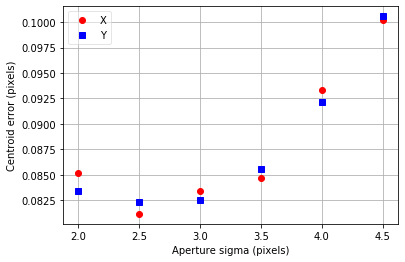

In [13]:
weight_list = np.arange(2.0,5.,0.5)
x0,y0 = 15.22,15.88
nTrials = 4000
star = MoffatPSF(x0=x0, y0=y0)
sigma_x = []
sigma_y = []

for sigma in weight_list:
    weight = GaussAp(sigma)
    xy = []
     # Run my loop of realizations
    for i in range(nTrials):
        img = star.realizeImage(n_pix=32,n_photon=flux)
        addBackground(img, n_bg)    
        xy_i = aperture_centroid(img,x,y,weight)
        xy.append(xy_i)
    # Put the results into a 2d array
    xy = np.vstack(xy).T
    # And get the centroid error
    sigma_x.append( np.std(xy[1]))
    sigma_y.append( np.std(xy[0]))
    # print out the mean positions, as a check
    print("At sigma",sigma,"mean x,y are ({:.3f},{:.3f})".format(np.mean(xy[1]),
                                                                np.mean(xy[0])))

# Now we can look at the results:
pl.plot(weight_list,sigma_x,'ro',label='X')
pl.plot(weight_list,sigma_y,'bs',label='Y')
pl.grid()
pl.xlabel('Aperture sigma (pixels)')
pl.ylabel('Centroid error (pixels)')
pl.legend(framealpha=0.5)
 
   

**Bonus question:** Using the formula in the notes, derive the *optimal* centroid accuracy $\sigma_e$ attainable for the Moffat profile with the chosen size, flux, and background noise.  How close is your best-choice Gaussian aperture to the optimum noise limit?

According to the notes, the Cramer-Rao bound for the variance of the x center of a star is the inverse of the Fisher information
$$F_{xx} = \frac{f^2}{n} \sum_{x,y} \left(\frac{\partial \textrm{PSF}}{\partial x}\right)^2.$$
We have two viable options here: compute this analytically by taking the derivative of the Moffat profile and then turning the sum into an integral; or compute this numerically.  Let's do this numerically, since we already have the code to calculate the Moffat PSF.

In [14]:
# I need the derivate of MoffatPSF with respect to x.  
# Let me make 2 Moffats that have x differing by a small amount +-dx from our nominal case.

# I'll use the values of x0,y0,hlr,n_bg,flux defined above.

# Small shift:
dx = 0.02
starplus = MoffatPSF(half_light_radius=hlr, x0=x0+dx, y0=y0)
starminus = MoffatPSF(half_light_radius=hlr, x0=x0-dx, y0=y0)
# Calculate the numerical derivative of the PSF by subtracting images
dPSF_dx = (starplus.draw(n_pix=32)-starminus.draw(n_pix=32)) / (2*dx)

# Now calculate the Fisher info
Fxx = (flux * flux / n_bg) * np.sum(dPSF_dx * dPSF_dx)

print("Optimal sigma_x:",1./np.sqrt(Fxx))

# Above I found that the best Gaussian weight obtained \sigma_x=0.084.
print("Ratio of Gaussian aperture to optimal:", 0.084 * np.sqrt(Fxx))
# So we could do about 10% better than the Gaussian aperture,
# which would be equivalent to having 20% more observing time or 2 more years of LSST!

Optimal sigma_x: 0.07703979502525513
Ratio of Gaussian aperture to optimal: 1.0903455801311932


## Exercise 3: Using a WCS

This exercise requires four fits files: `old_image.fits`, `new_image.fits`, `old_catalog.fits`, and `new_catalog.fits`. Please [download these files](https://northwestern.box.com/s/9k7vtoa5lbfsohw2dm9wdxz0jc66mh7r), and place them in the same directory as this notebook.  

The 2 FITS images are from the [Dark Energy Survey (DES)](https://www.darkenergysurvey.org/), named `old_image.fits` and `new_image.fits`, and they overlap on the sky. According to Gaia DR2, there is a fast-moving star located at roughly $(\alpha,\delta)=$(29.91148,-8.212267). If you display these two images using DS9, then align them using the `Frame->Match->Frame->WCS` option, you will be able to move your cursor to those coordinates actually see the star move.

We also have catalogs (FITS tables) named `old_catalog.fits` and `new_catalog.fits` that contain the precise pixel centroids measured by `SExtractor` on these frames.  Your exercise is to extract the WCS from each image's header using astropy, apply it to the $(x,y)$ coordinates to obtain $(\alpha,\delta)$ for this star in each image, and then estimate its proper motion.

**(a)** Get a WCS and the `MJD-OBS` out of headers. \[MJD is Modified Julian Date.  Basically it gives the time of the exposure in units of days since some reference moment.\]

In [15]:
# I'll start you off by constructing an astropy WCS from the first image
h = pf.getheader('old_image.fits')
wcs_old = WCS(h)
mjd_old = h['MJD-OBS']

# And here's an example of using the WCS to map to the sky:
radec = wcs_old.pixel_to_world(1834,1620)
print(radec)
print(radec.ra.degree)

<SkyCoord (ICRS): (ra, dec) in deg
    (29.75015272, -8.32410181)>
29.750152720824026


In [16]:
# Here's the second image:
h = pf.getheader('new_image.fits')
wcs_new = WCS(h)
mjd_new = h['MJD-OBS']

**(b)** Now read the FITS catalogs into tables.  We will use the columns `XWIN_IMAGE` and `YWIN_IMAGE` to give us the pixel coordinates, with `ERRAWIN_IMAGE` giving the rough uncertainty on each (in units of pixels, 1 pixel = 0.264 arcsec).

By whatever means you choose, figure out which row in each catalog corresponds to the fast-moving star at the coordinates given above.  Then use the WCS's to obtain the ICRS RA & Dec measured for this star on these two images.

In [17]:
# I'll start you off by giving the command to read in the catalog to a table:
cat_old = pf.getdata('old_catalog.fits',1)

In [18]:
# Let's locate the desired star by mapping the whole catalog to sky coordinates, and using
# astropy's ability to give distances between SkyCoords and find the one that's close
# to the Gaia position.
radec = wcs_old.pixel_to_world(cat_old['XWIN_IMAGE'],cat_old['YWIN_IMAGE'])

# Find the mininum distance between a catalog object and our Gaia target
target = co.SkyCoord(ra=29.91148,dec=-8.212267,frame='icrs',unit='deg')
dist = radec.separation(target)
index_old = np.argmin(dist)

# Save the coordinats of this star
coords_old = radec[index_old]
sigma_old = cat_old['ERRAWIN_IMAGE'][index_old] * 0.264 # Change into arcseconds
print("Star is index",index_old,"in old image at",coords_old)

# Now repeat for the new catalog
cat_new = pf.getdata('new_catalog.fits',1)
radec = wcs_new.pixel_to_world(cat_new['XWIN_IMAGE'],cat_new['YWIN_IMAGE'])
dist = radec.separation(target)
index_new = np.argmin(dist)
print(dist[index_new]) ###

# Save the coordinats of this star in the new image
coords_new = radec[index_new]
sigma_new = cat_new['ERRAWIN_IMAGE'][index_new] * 0.264 # Change into arcseconds
print("Star is index",index_new,"in new image at",coords_new)


Star is index 252 in old image at <SkyCoord (ICRS): (ra, dec) in deg
    (29.9115171, -8.21232326)>
0d00m01.4971s
Star is index 129 in new image at <SkyCoord (ICRS): (ra, dec) in deg
    (29.91185931, -8.21244591)>


**(c)** Using these two sky coordinates, estimate the rate of proper motion (in mas/yr) of the star between the two exposures.  Note that proper motions are traditionally given in real angular motions, so that (RA PM) = (difference in RA) * cos(dec) / (time interval). \[You can ignore the fact that there might be parallax motion mixed in here.\]

Give an uncertainty for our measurement as well.  Here we have to be careful, because `ERRAWIN_IMAGE` includes only the shot-noise errors.  It does not include the contribution from atmospheric turbulence, which we know is dominant for brighter stars.  So let's add another 10 mas of uncertainty in quadrature to each coordinate of each measurement as a guess of the size of the turbulence.

Does the DES measurement agree with Gaia's estimates?  Are there any reasons it might disagree?
```
pmra  =  326.06  +- 0.94	mas/yr
pmdec = -124.12 +- 0.81	mas/yr
```

In [19]:
# First get the time interval, in years:
dt = (mjd_new - mjd_old) / 365.25 #(number of days in a Julian year)
print("Years between observations:",dt)

# Now get the change in dec and RA, which we convert to milliarcsec
dRA = (coords_new.ra.deg - coords_old.ra.deg) * 3600 * 1000. * np.cos(coords_new.dec.rad)
dDec = (coords_new.dec.deg - coords_old.dec.deg) * 3600 * 1000. 

# The uncertainty in the difference is the quadrature sum of the individual errors
sigma_diff = np.sqrt( sigma_new**2 + sigma_old**2) * 1000. # convert to mas.
# Add 2 exposures' worth of 10 mas turbulence to the sigma
sigma_diff = np.sqrt(sigma_diff**2 + 2 * 10.**2)

# Now divide by time to get the rates of motion.
print("PMRA:  {:.2f} +- {:.2f}".format(dRA/dt, sigma_diff/dt))
print("PMDec: {:.2f} +- {:.2f}".format(dDec/dt, sigma_diff/dt))

Years between observations: 3.958820646817245
PMRA:  308.00 +- 3.92
PMDec: -111.53 +- 3.92


My results have come out about 4 sigma off in PMRA and 3 sigma in PMDec from Gaia, which is too large to be attributable to noise.

We have neglected parallax, which might be an issue - but actually this is a pretty distant star with small parallax according to this info from Gaia DR2:
```
ID 2463291012727113216
RA 29.91148717728625 deg +- 0.406411467620237  mas	
Dec -8.212267040783548 deg +- 0.40843308727462063 mas	
par 3.87 mas +- 0.49	
G = 19.85
```

Another issue we have not address is chromatic refraction.  Our discrepancy in PMRA is about 18 mas/yr, or 72 mas total over the 4-year interval (a bit smaller in PMDec).  That is a bit large for r-band DCR unless this is an unusual-color star.  On the other hand the WCS in the image header is also neglecting effects like tree rings, and these things together could account for the difference.  We have a much more precise astrometric solution for DES images than can be stored in the header, and soon we will be calculating proper motions for all the stars, including chromatic terms!